In [49]:
suppressMessages({
    library(fields)
    library(ncdf4)
    hgd()
    rm(list = ls())
})


httpgd server running at:
  http://127.0.0.1:41919/live?token=AoLQov0X


[1] "Row sums:"
 Site_1  Site_2  Site_3  Site_4  Site_5  Site_6  Site_7  Site_8  Site_9 Site_10 
      1       1       1       1       1       1       1       1       1       1 


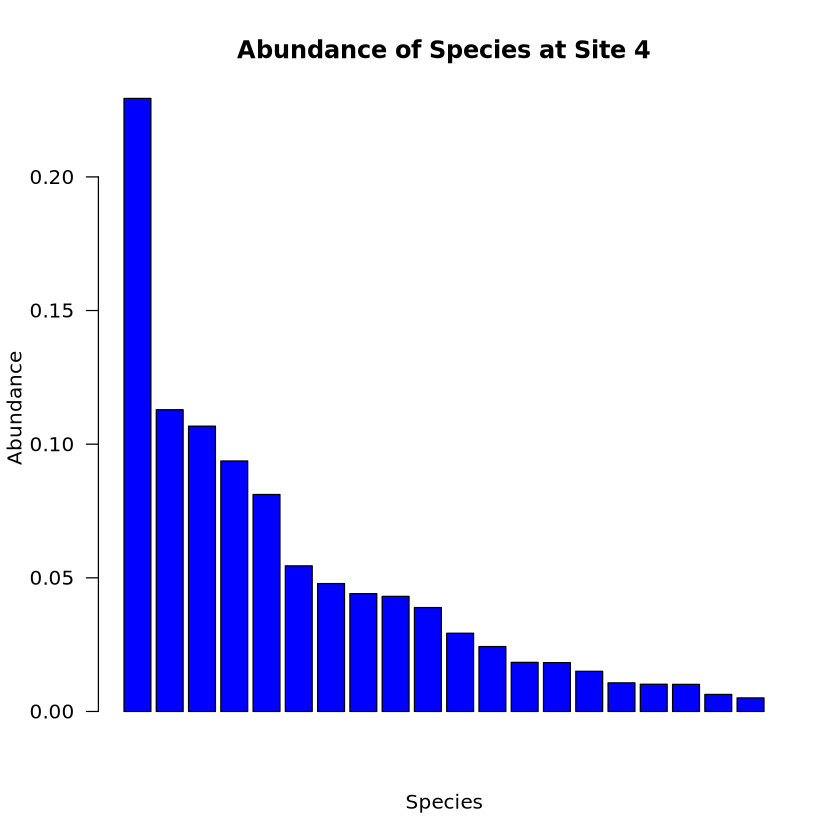

In [45]:
#----------------------------------------------------------------
# Create synthetic eDNA data
#----------------------------------------------------------------
source("../3_src/1_data/create_synthetic_data.R")

otu_table <- create_synthetic_rel_abundance_data(no_sites = 10, no_species = 20, seed = 1)

# Plotting row
row <- 4

# Order species by reducing abundance
sorted_otu_table <- t(apply(otu_table, 1, function(x) sort(x, decreasing = TRUE)))

# Set the background color to white
par(bg = "white")
# Plot the specified row
barplot(as.numeric(sorted_otu_table[row, ]), main = paste("Abundance of Species at Site", row), xlab = "Species", ylab = "Abundance", las = 2, col = "blue")

# Sum the rows and columns
row_sums <- rowSums(otu_table)

# Print the sums
print("Row sums:")
print(row_sums)


In [46]:
#----------------------------------------------------------------
# load in data
#----------------------------------------------------------------

midnor <- nc_open("/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc")

sinmod_data <- midnor

# Obtain the grid information
xc <- dim(ncvar_get(sinmod_data, "xc"))[1]
yc <- dim(ncvar_get(sinmod_data, "yc"))[1]

# Obtain depth information to check for land
depth <- ncvar_get(sinmod_data, "depth")

# Print
print(paste("Grid size: ", xc, "x", yc))

# List all variables in the NetCDF file
variables <- names(sinmod_data$var)
print(variables)


[1] "Grid size:  950 x 555"
 [1] "grid_mapping"    "LayerDepths"     "depth"           "DXxDYy"         
 [5] "u_velocity"      "v_velocity"      "elevation"       "temperature"    
 [9] "salinity"        "ice_thickness"   "ice_compactness" "salinity_ice"   


In [47]:
source("../3_src/1_data/fetch_sinmod_data.R")
# Set random seed
set.seed(1)

# Randomly sample the grid
# Get the value at (1,1) (which is considered invalid)
invalid_value <- depth[1, 1]

no_sites <- nrow(otu_table)

# Exclude locations where depth is equal to the value at (1,1)
valid_locations <- which(depth != invalid_value, arr.ind = TRUE)
sampled_locations <- valid_locations[sample(nrow(valid_locations), no_sites), ]
colnames(sampled_locations) <- c('x', 'y')

# Obtain the SINMOD env data at sampled locations
# We will choose temperature, salinity, u_velocity, v_velocity
env_variables <- c("temperature", "salinity", "u_velocity", "v_velocity") # Can add "elevation" if needed

df <- fetch_sinmod_data(sinmod_data, sampled_locations, env_variables)

In [48]:
# Save the resulting data frame as a CSV file
write.csv(df, "../1_data/2_processed/training/midnor_training.csv", row.names = FALSE)

# Save the sampled locations as a CSV file
write.csv(sampled_locations, "../1_data/1_raw/synthetic_abundance/sampled_locations.csv", row.names = FALSE)

# Save the eDNA data (otu_table) as a CSV file
write.csv(otu_table, "../1_data/1_raw/synthetic_abundance/otu_table.csv", row.names = TRUE)
